In [1]:
# Combine datasets
import pandas as pd

# Load datasets
airquality_df = pd.read_csv('luftkvalitet.csv')
traffic_df = pd.read_csv('trafikkdata.csv', sep=';')


In [2]:
airquality_df.describe(include='all')

,Fra-tid,Til-tid,Elgeseter PM10µg/m³,Elgeseter PM2.5µg/m³,Elgeseter NO2µg/m³
count,8761,8761,8761.000000,8761.000000,8761.000000
unique,8761,8761,NaN,NaN,NaN
top,30.09.2022 00:00,30.09.2022 01:00,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN
mean,NaN,NaN,12.755967,5.652262,16.531764
std,NaN,NaN,17.557762,5.645963,13.598096
min,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,3.760000,2.600000,6.500000
50%,NaN,NaN,8.400000,4.390000,12.870000
75%,NaN,NaN,14.700000,6.700000,22.500000


In [3]:
traffic_df.describe(include='all')


,Dato,Fra tidspunkt,Til tidspunkt,Trafikkmengde
count,8784,8784,8784,8784
unique,366,24,24,2108
top,2022-10-30,00:00,01:00,68
freq,25,366,366,37


In [4]:

airquality_df['Fra-tid'] = pd.to_datetime(airquality_df['Fra-tid'], format='%d.%m.%Y %H:%M')

airquality_df['Date'] = airquality_df['Fra-tid'].dt.date
airquality_df['Hour'] = airquality_df['Fra-tid'].dt.hour

airquality_df['Date'] = pd.to_datetime(airquality_df['Date'])

traffic_df['Date'] = pd.to_datetime(traffic_df['Dato'], format='%Y-%m-%d')
traffic_df['Hour'] = pd.to_datetime(traffic_df['Fra tidspunkt'], format='%H:%M').dt.hour

combined_df = pd.merge(airquality_df, traffic_df, on=['Date', 'Hour'], suffixes=('_airquality', '_traffic'))

combined_df['Year'] = combined_df['Date'].dt.year
combined_df['Month'] = combined_df['Date'].dt.month
combined_df['Day'] = combined_df['Date'].dt.day
combined_df = combined_df.drop(columns=['Fra-tid', 'Dato', 'Fra tidspunkt', 'Til-tid', 'Til tidspunkt', 'Date'])
combined_df["Trafikkmengde"] = pd.to_numeric(combined_df["Trafikkmengde"], errors='coerce').astype("Int64")
combined_df.head()

,Elgeseter PM10µg/m³,Elgeseter PM2.5µg/m³,Elgeseter NO2µg/m³,Hour,Trafikkmengde,Year,Month,Day
0,13.2,5.6,25.89,0,179,2022,9,30
1,11.8,5.6,16.59,1,136,2022,9,30
2,10.1,6.0,15.17,2,82,2022,9,30
3,8.0,4.7,17.14,3,79,2022,9,30
4,8.5,5.1,25.88,4,67,2022,9,30


In [5]:
combined_df.dtypes

Elgeseter PM10µg/m³     float64
Elgeseter PM2.5µg/m³    float64
Elgeseter NO2µg/m³      float64
Hour                      int32
Trafikkmengde             Int64
Year                      int32
Month                     int32
Day                       int32
dtype: object

In [6]:
# Divided the combined dataset into two datasets train and test 0. 8 and 0.2

train_df = combined_df.sample(frac=0.8, random_state=0)
test_df = combined_df.drop(train_df.index)

train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [7]:
# Divide the the train df into X and y
# y is Elgeseter PM10µg/m³	Elgeseter PM2.5µg/m³	Elgeseter NO2µg/m³
# X is the rest of the columns
X_train = train_df.drop(columns=['Elgeseter PM10µg/m³', 'Elgeseter PM2.5µg/m³', 'Elgeseter NO2µg/m³'])
y_train = train_df[['Elgeseter PM10µg/m³', 'Elgeseter PM2.5µg/m³', 'Elgeseter NO2µg/m³']]

X_train_xgb = X_train.copy()
y_train_xgb = y_train.copy()

X_train.describe(include='all')

,Hour,Trafikkmengde,Year,Month,Day
count,7009.000000,7003.0,7009.000000,7009.000000,7009.000000
mean,11.501213,934.217335,2022.741618,6.546012,15.766586
std,6.922230,640.962823,0.437776,3.451296,8.818164
min,0.000000,27.0,2022.000000,1.000000,1.000000
25%,6.000000,308.5,2022.000000,4.000000,8.000000
50%,12.000000,897.0,2023.000000,7.000000,16.000000
75%,17.000000,1521.0,2023.000000,10.000000,23.000000
max,23.000000,2438.0,2023.000000,12.000000,31.000000


In [8]:
y_train.describe(include='all')

,Elgeseter PM10µg/m³,Elgeseter PM2.5µg/m³,Elgeseter NO2µg/m³
count,7009.000000,7009.000000,7009.000000
mean,12.733217,5.663836,16.627914
std,17.400761,5.638143,13.646529
min,0.000000,0.000000,0.000000
25%,3.760000,2.600000,6.500000
50%,8.440000,4.400000,13.000000
75%,14.800000,6.700000,22.600000
max,535.700000,64.700000,90.700000


In [9]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

base_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
mult_regressor = MultiOutputRegressor(base_regressor)

mult_regressor.fit(X_train, y_train)

predictions = mult_regressor.predict(X_train)
print(predictions)



[[ 0.395   1.772   2.321 ]
 [ 1.7251  0.9406  1.444 ]
 [ 9.521   4.426  15.0035]
 ...
 [ 7.8477  3.7276  7.13  ]
 [92.807  10.6682 34.997 ]
 [ 6.942   5.652  42.465 ]]


In [10]:
X_test = test_df.drop(columns=['Elgeseter PM10µg/m³', 'Elgeseter PM2.5µg/m³', 'Elgeseter NO2µg/m³'])
y_test = test_df[['Elgeseter PM10µg/m³', 'Elgeseter PM2.5µg/m³', 'Elgeseter NO2µg/m³']]

In [11]:
# Measure accuraci to the model using test set the model is a multioutput regressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

predictions = mult_regressor.predict(X_test)
print(predictions)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')



[[10.77724319  5.30565227 15.8838    ]
 [23.5942      7.2341     28.6084    ]
 [13.8594      2.4228     20.4747    ]
 ...
 [15.7973      5.121      20.85093335]
 [15.45796756  5.44855025 20.1206    ]
 [14.2586      4.346      15.4367    ]]
MSE: 57.8117480390844
MAE: 4.529114120726878
R2: 0.6812088424575128


In [12]:
from joblib import dump

dump(mult_regressor, 'models/multi_random_forest.joblib')

['models/multi_random_forest.joblib']

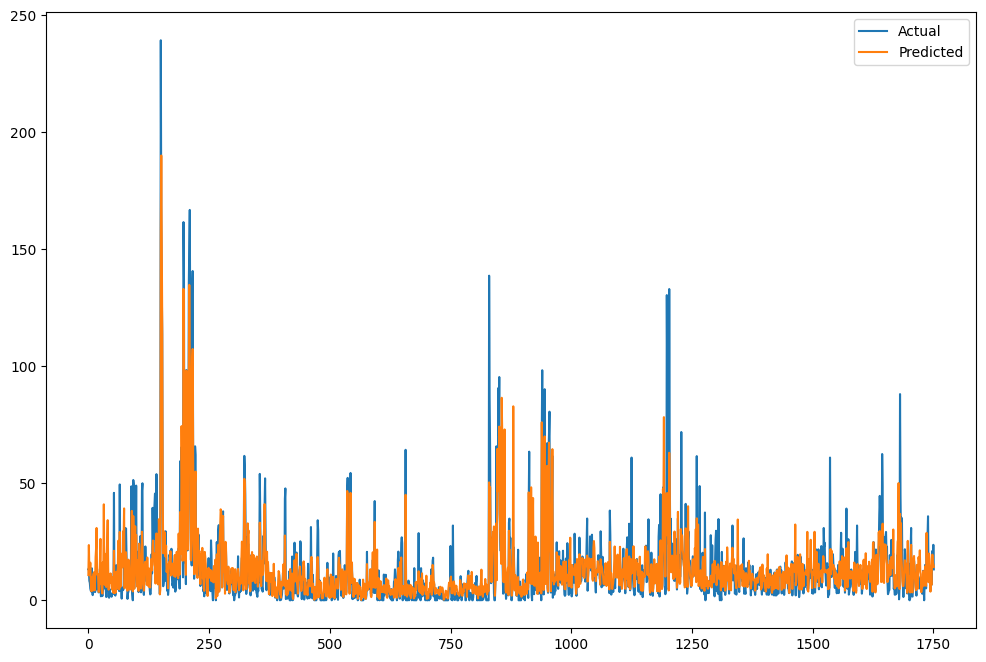

In [13]:
# Plot a graph that shows the predicted values and the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.plot(y_test['Elgeseter PM10µg/m³'].values, label='Actual')
plt.plot(predictions[:, 0], label='Predicted')

plt.legend()
plt.show()


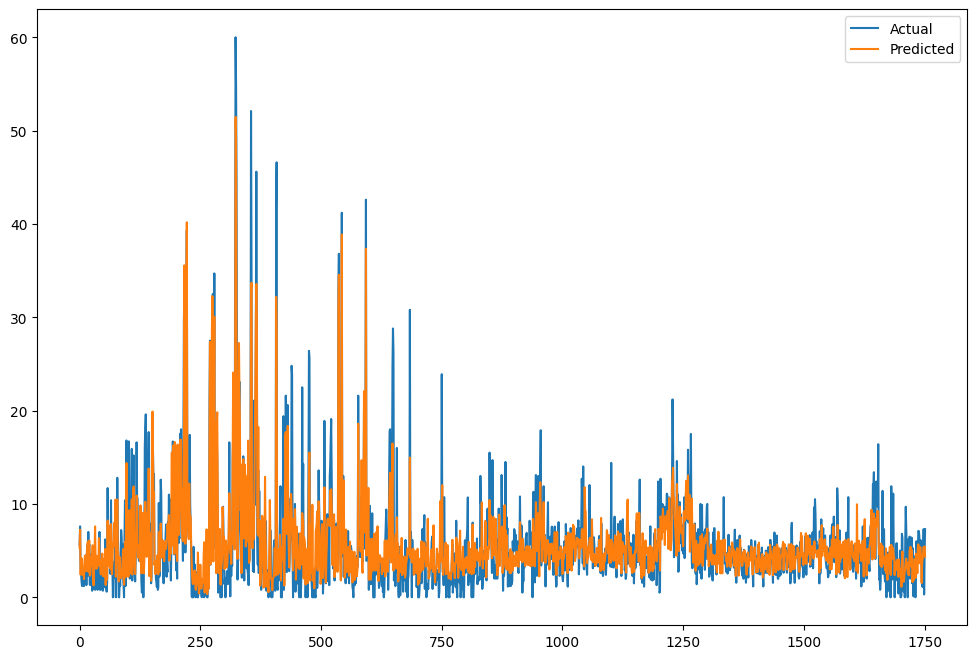

In [14]:

plt.figure(figsize=(12,8))

plt.plot(y_test['Elgeseter PM2.5µg/m³'].values, label='Actual')
plt.plot(predictions[:, 1], label='Predicted')



plt.legend()
plt.show()

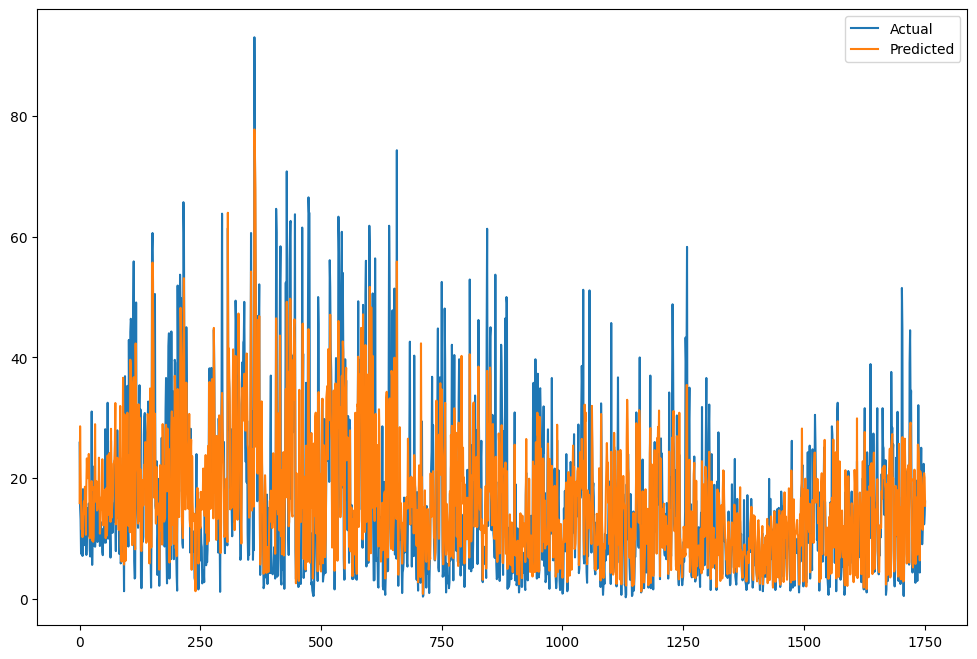

In [15]:
plt.figure(figsize=(12,8))

plt.plot(y_test['Elgeseter NO2µg/m³'].values, label='Actual')
plt.plot(predictions[:, 2], label='Predicted')

plt.legend()
plt.show()

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# --- Step 1: Fill Missing Values using KNNImputer ---

# Create separate imputers for features and targets
imputer_X = KNNImputer(n_neighbors=5)
imputer_y = KNNImputer(n_neighbors=5)

# Impute features
X_train = pd.DataFrame(imputer_X.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer_X.transform(X_test), columns=X_test.columns)

# Impute targets
y_train = pd.DataFrame(imputer_y.fit_transform(y_train), columns=y_train.columns)
y_test = pd.DataFrame(imputer_y.transform(y_test), columns=y_test.columns)

# --- Step 2: Scale the Data ---

# Scale features
scaler_X = StandardScaler()
X_train_np = scaler_X.fit_transform(X_train.astype(np.float32))
X_test_np = scaler_X.transform(X_test.astype(np.float32))

# For targets, converting to NumPy array directly (or scale if needed)
y_train_np = y_train.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.float32)

# --- Step 3: Create a Train/Validation Split (90/10) ---

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_np, y_train_np, test_size=0.1, random_state=42
)

# --- Step 4: Convert NumPy Arrays to PyTorch Tensors ---

# Training tensors
X_train_tensor = torch.tensor(X_train_split, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_split, dtype=torch.float32)

# Validation tensors
X_val_tensor = torch.tensor(X_val_split, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_split, dtype=torch.float32)

# Test tensors
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

# --- Step 5: Define the PyTorch Model for Multi-Output Regression ---

class MultiOutputRegressor(nn.Module):
    import torch.nn as nn

class MultiOutputRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob=0.05):
        super(MultiOutputRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 128),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
        
    def forward(self, x):
        return self.model(x)


input_dim = X_train_tensor.shape[1]
output_dim = y_train_tensor.shape[1]
model = MultiOutputRegressor(input_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Step 6: Train the Model with Validation ---

train_losses = []
val_losses = []

epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass on training data
    outputs = model(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    
    if torch.isnan(train_loss):
        print(f"Training loss is NaN at epoch {epoch+1}. Stopping training.")
        break
        
    train_loss.backward()
    optimizer.step()
    
    # Evaluate on validation set without gradient tracking
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    # Print training and validation loss every 50 epochs
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}] - Training Loss: {train_loss.item():.4f} - Validation Loss: {val_loss.item():.4f}')
    
    # Save losses for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    # Switch back to training mode for the next epoch
    model.train()



Epoch [500/5000] - Training Loss: 125.9188 - Validation Loss: 157.9959
Epoch [1000/5000] - Training Loss: 110.7428 - Validation Loss: 136.7188
Epoch [1500/5000] - Training Loss: 98.9100 - Validation Loss: 117.9118
Epoch [2000/5000] - Training Loss: 88.0986 - Validation Loss: 112.1758
Epoch [2500/5000] - Training Loss: 81.9011 - Validation Loss: 107.1700
Epoch [3000/5000] - Training Loss: 75.7515 - Validation Loss: 105.5038
Epoch [3500/5000] - Training Loss: 73.1394 - Validation Loss: 103.4626
Epoch [4000/5000] - Training Loss: 70.0653 - Validation Loss: 100.0507
Epoch [4500/5000] - Training Loss: 65.8562 - Validation Loss: 97.6350
Epoch [5000/5000] - Training Loss: 65.6816 - Validation Loss: 96.6842


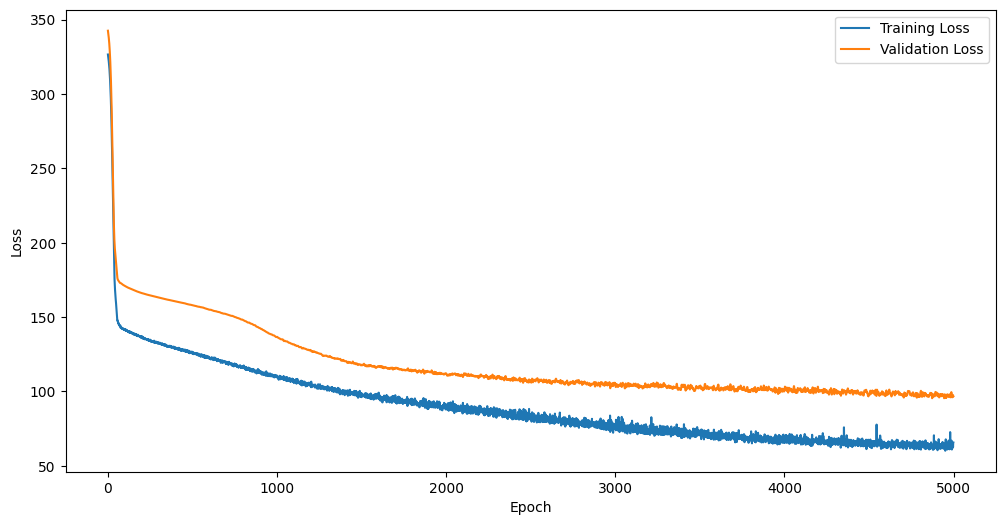

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    
test_predictions_np = test_predictions.numpy()
print("Test Predictions:")
print(test_predictions_np)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_np, test_predictions_np)
mae = mean_absolute_error(y_test_np, test_predictions_np)
r2 = r2_score(y_test_np, test_predictions_np)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

Test Predictions:
[[10.419772   3.68352   13.095362 ]
 [28.132748   6.90538   29.427893 ]
 [14.855369   6.832207  21.388062 ]
 ...
 [16.41967    3.8474288 18.400928 ]
 [16.99596    5.3853183 19.061628 ]
 [14.599448   5.566014  18.267298 ]]
MSE: 75.85938262939453
MAE: 4.946606159210205
R2: 0.548649863726053


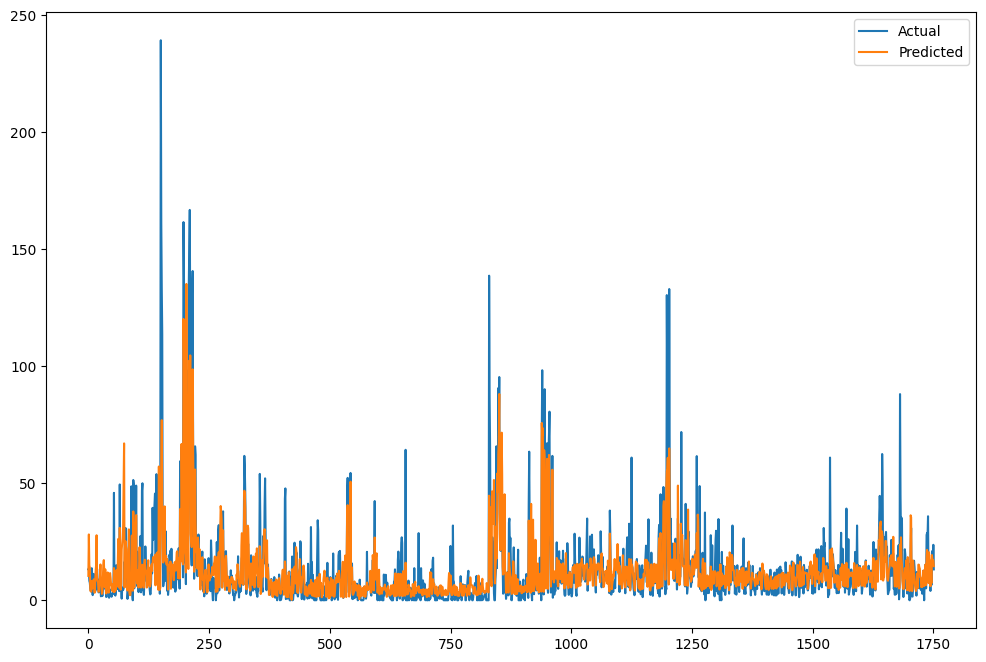

In [19]:

plt.figure(figsize=(12,8))

plt.plot(y_test['Elgeseter PM10µg/m³'].values, label='Actual')
plt.plot(test_predictions_np[:, 0], label='Predicted')

plt.legend()
plt.show()


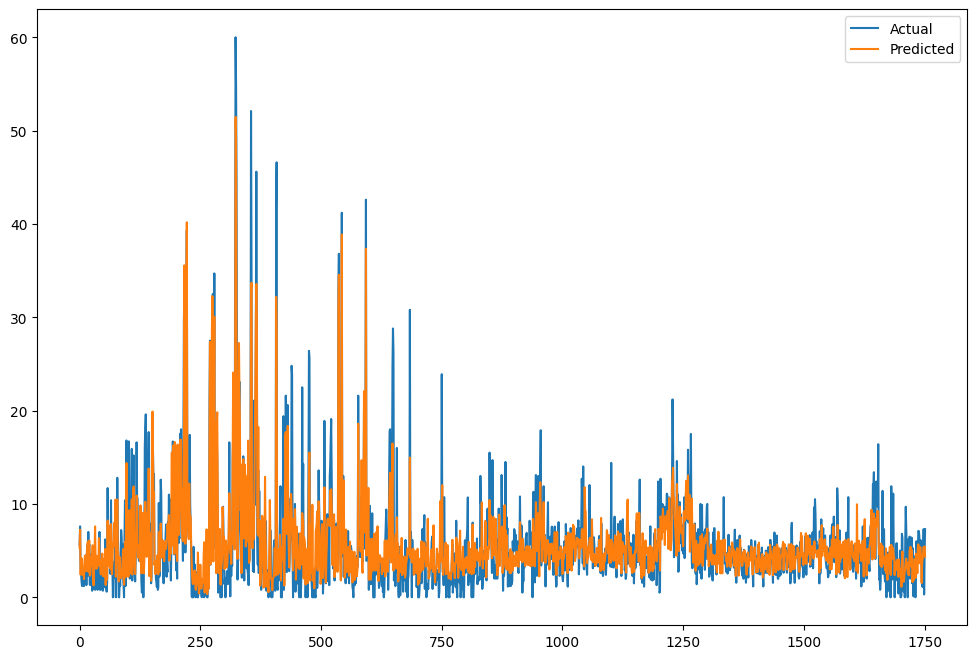

In [20]:

plt.figure(figsize=(12,8))

plt.plot(y_test['Elgeseter PM2.5µg/m³'].values, label='Actual')
plt.plot(predictions[:, 1], label='Predicted')



plt.legend()
plt.show()

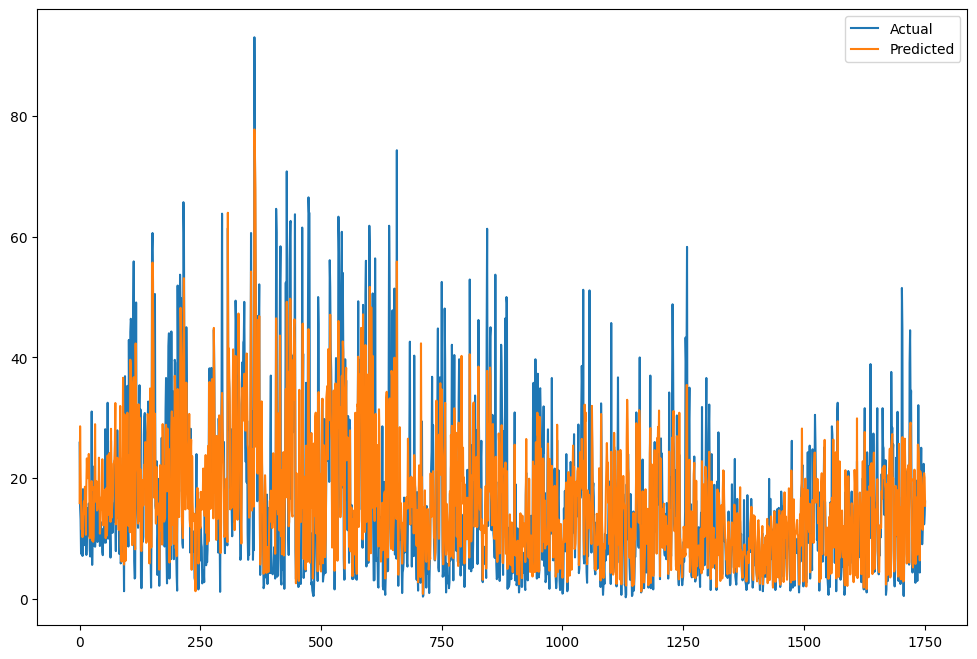

In [21]:
plt.figure(figsize=(12,8))

plt.plot(y_test['Elgeseter NO2µg/m³'].values, label='Actual')
plt.plot(predictions[:, 2], label='Predicted')

plt.legend()
plt.show()

In [22]:
torch.save(model.state_dict(), 'multioutput_regressor.pth')

In [23]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [24]:
multi_output_xgb_regressor = MultiOutputRegressor(xgb.XGBRegressor( random_state=42))
multi_output_xgb_regressor.fit(X_train_xgb, y_train_xgb)

y_pred_xgb = multi_output_xgb_regressor.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)


In [25]:
print(f'MSE: {mse_xgb}')
print(f'MAE: {mae_xgb}')
print(f'R2: {r2_xgb}')

MSE: 61.080863437402165
MAE: 4.657516637984923
R2: 0.6644196228260069


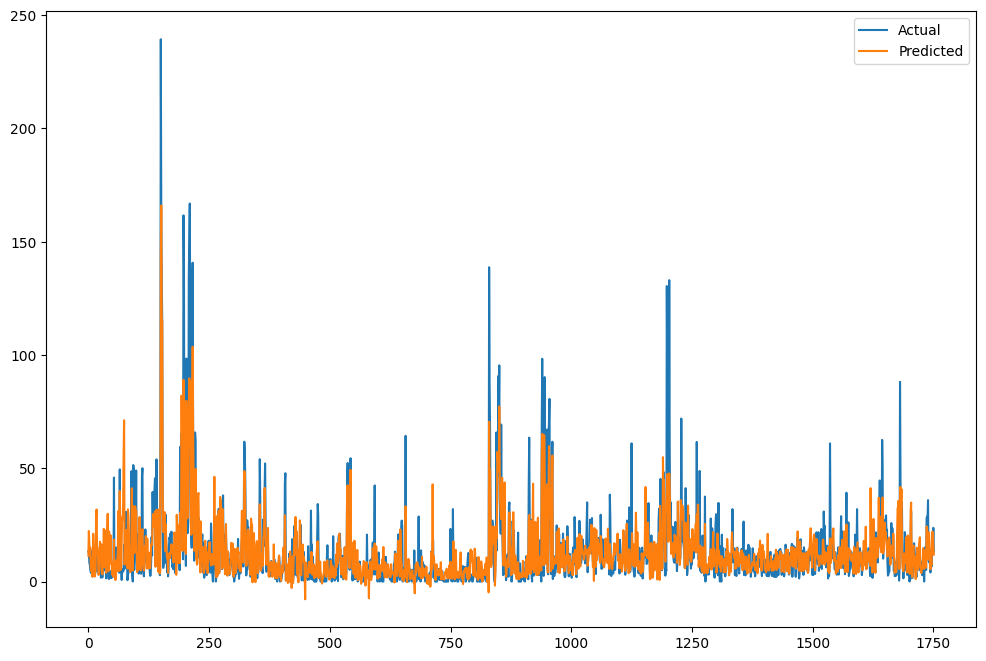

In [26]:
plt.figure(figsize=(12,8))

plt.plot(y_test['Elgeseter PM10µg/m³'].values, label='Actual')
plt.plot(y_pred_xgb[:, 0], label='Predicted')

plt.legend()
plt.show()

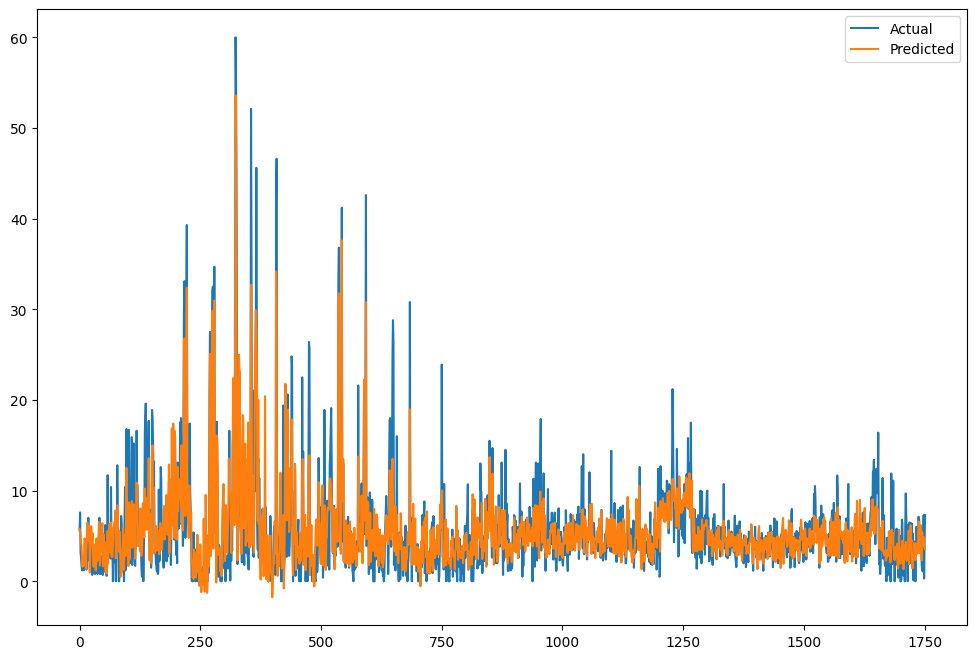

In [27]:
plt.figure(figsize=(12,8))

plt.plot(y_test['Elgeseter PM2.5µg/m³'].values, label='Actual')
plt.plot(y_pred_xgb[:, 1], label='Predicted')

plt.legend()
plt.show()

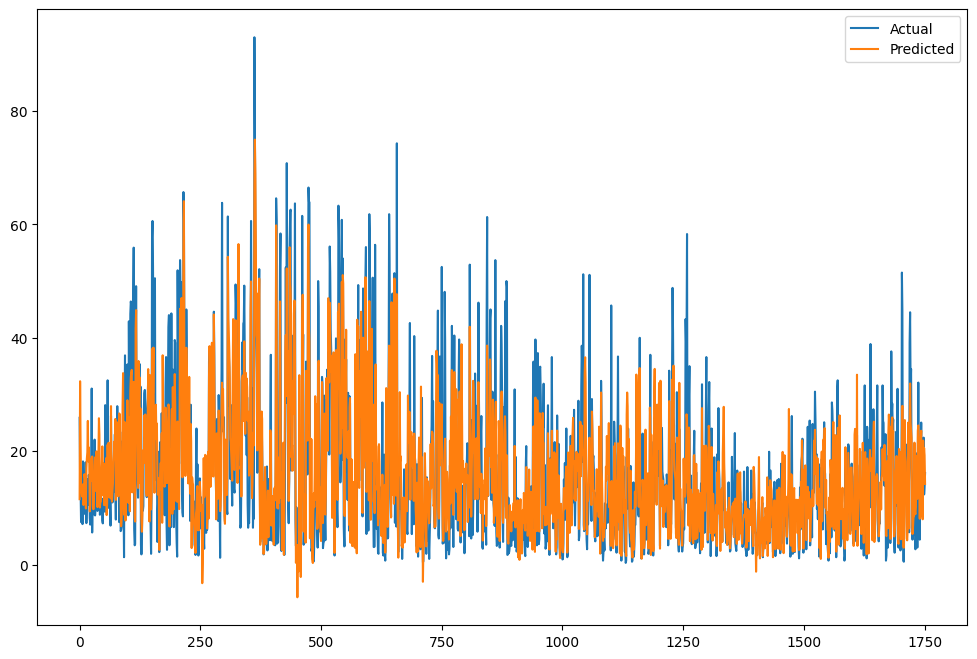

In [28]:
plt.figure(figsize=(12,8))

plt.plot(y_test['Elgeseter NO2µg/m³'].values, label='Actual')
plt.plot(y_pred_xgb[:, 2], label='Predicted')

plt.legend()
plt.show()